# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [ ]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score
!pip install -U -q datasets pyarrow[full]
!pip install chromadb

!pip install -q sentence-transformers
!pip install -q huggingface_hub
!pip install -q langchain-huggingface
!pip install -q transformers
!pip install -q torch
!pip install evaluate sacrebleu rouge_score ragas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
import glob
import zipfile
import os
from langchain.document_loaders import DirectoryLoader, TextLoader
import re
import string
import logging
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from typing import List, Dict, Any
import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas import evaluate as ragas_evaluate
from datasets import Dataset

import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install -U langchain-community

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/rag_legal.zip'

# Define the directory where you want to extract the files
extracted_dir_path = '/content/rag_legal'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extracted_dir_path):
    os.makedirs(extracted_dir_path)

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_path)
        print(f"Successfully extracted {zip_file_path} to {extracted_dir_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted /content/rag_legal.zip to /content/rag_legal


In [ ]:

data = "/content/rag_legal"

# Check if the directory exists before attempting to load
if not os.path.exists(data):
    print(f"Error: Directory not found: '{data}'. Please ensure the zip file has been extracted.")
else:
    loader = DirectoryLoader(data, glob="**/*.txt", loader_cls=TextLoader, show_progress=True)
    documents = loader.load()

    print(f"Number of documents: {len(documents)}")
    print(f"First document: {documents[0]}")

100%|██████████| 698/698 [00:00<00:00, 1049.90it/s]

Number of documents: 698
First document: page_content='﻿Exhibit 2.1 


Execution Version 


AGREEMENT AND PLAN OF MERGER 


among 


ELI LILLY AND COMPANY, 


TYTO ACQUISITION CORPORATION, 


and 


PREVAIL THERAPEUTICS INC. 


Dated as of December 14, 2020  








________________


TABLE OF CONTENTS   ARTICLE I THE OFFER    2  Section 1.1.  The Offer    2  Section 1.2.  Company Consent; Schedule 14D-9    4  Section 1.3.  Stockholder Lists    5  ARTICLE II THE MERGER    5  Section 2.1.  The Merger    5  Section 2.2.  Closing; Effective Time    5  Section 2.3.  Effects of the Merger    6  Section 2.4.  Certificate of Incorporation and Bylaws of the Surviving Corporation    6  Section 2.5.  Directors and Officers    6  Section 2.6.  Merger Without a Vote of Stockholders    6  ARTICLE III EFFECT OF THE MERGER ON THE CAPITAL STOCK OF THE CONSTITUENT CORPORATIONS    6  Section 3.1.  Conversion of Securities    6  Section 3.2.  Treatment of Equity Awards    7  Section 3.3.  Dissenting Sha

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [ ]:
def preprocess_text(documents):

  preprocessed_documents = []
  email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
  phone_regex = r'\b(?:\+\d{1,3}\s?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b'

  for doc in documents:

    new_document= doc.copy()
    text = new_document.page_content
    # Remove email and phone number
    text = re.sub(email_regex, '', text)
    text = re.sub(phone_regex, '', text)

   #Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s., ;\'"-]', "", text)
    #To lowercase
    text = text.lower()
    #Remove stopwords
    tokens= text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    #Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    new_document.page_content = text
    preprocessed_documents.append(new_document)

  print("processing is done")
  return preprocessed_documents
preprocessed_documents = preprocess_text(documents)

/tmp/ipython-input-3132552278.py:9: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  new_document= doc.copy()


processing is done


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [ ]:
# Calculate the average, maximum and minimum document length.
length_stats= [len(doc.page_content.split()) for doc in preprocessed_documents]
average_length = np.mean(length_stats)
max_length = np.max(length_stats)
min_length = np.min(length_stats)


print(f"Average length: {average_length}")
print(f"Maximum length: {max_length}")
print(f"Minimum length: {min_length}")

Average length: 9110.313753581662
Maximum length: 85966
Minimum length: 148


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

Most common words:
company: 132468

Least common words:
shall: 104671

Least common words:
section: 74831

Least common words:
agreement: 66080

Least common words:
parent: 49245

Least common words:
party: 41814

Least common words:
material: 33326

Least common words:
date: 29924

Least common words:
merger: 29011

Least common words:
respect: 28346

Least common words:
may: 26996

Least common words:
applicable: 26370

Least common words:
including: 26328

Least common words:
subsidiaries: 24888

Least common words:
prior: 23299

Least common words:
time: 23265

Least common words:
agreement,: 22613

Least common words:
stock: 22275

Least common words:
b: 22140

Least common words:
information: 20940

Least common words:
transnet.: 1


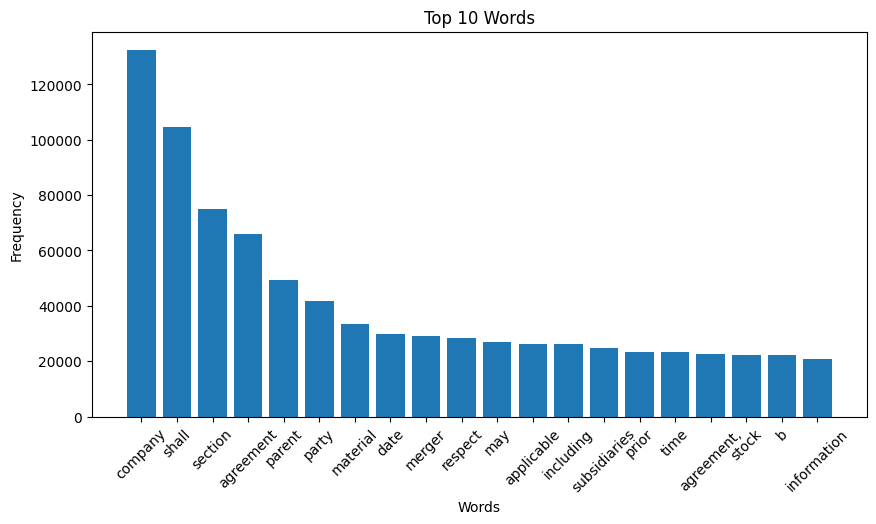

authorised.: 1


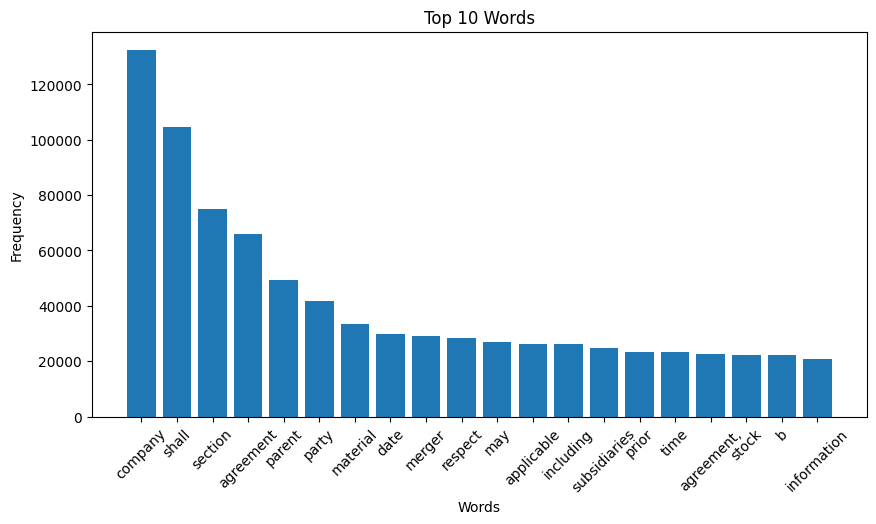

transnet;: 1


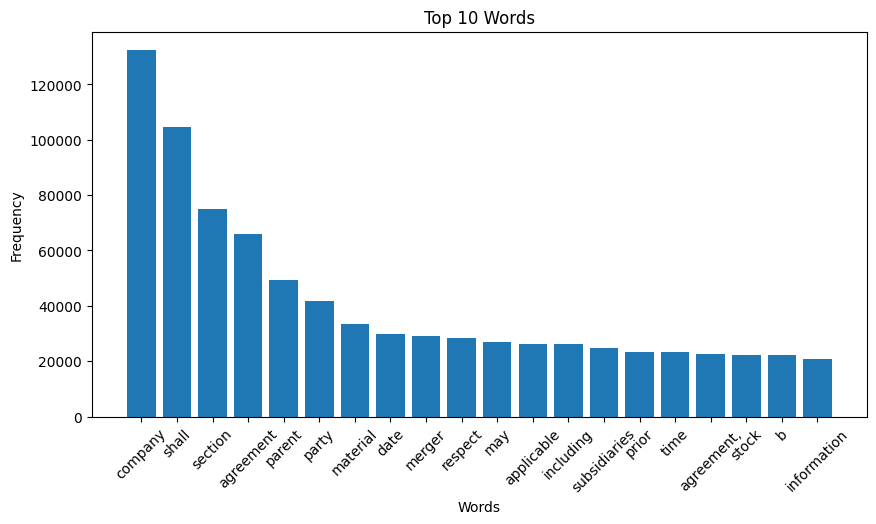

clientele: 1


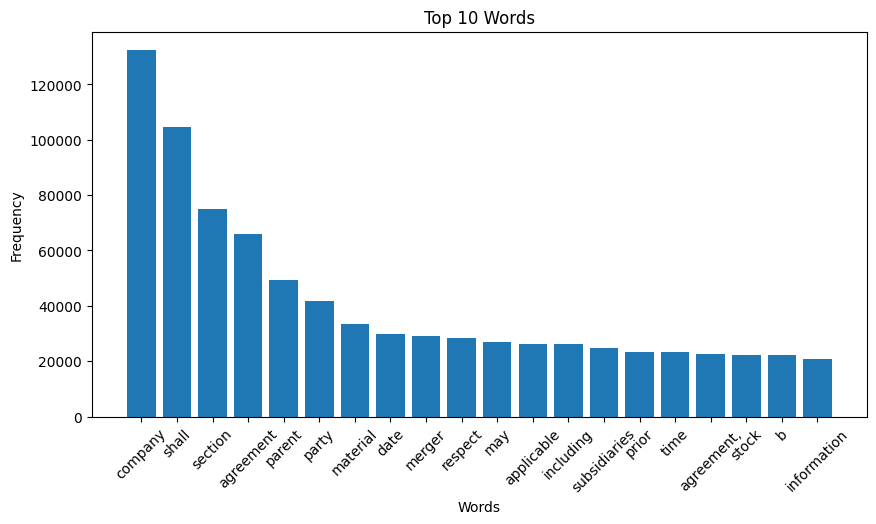

prosperity: 1


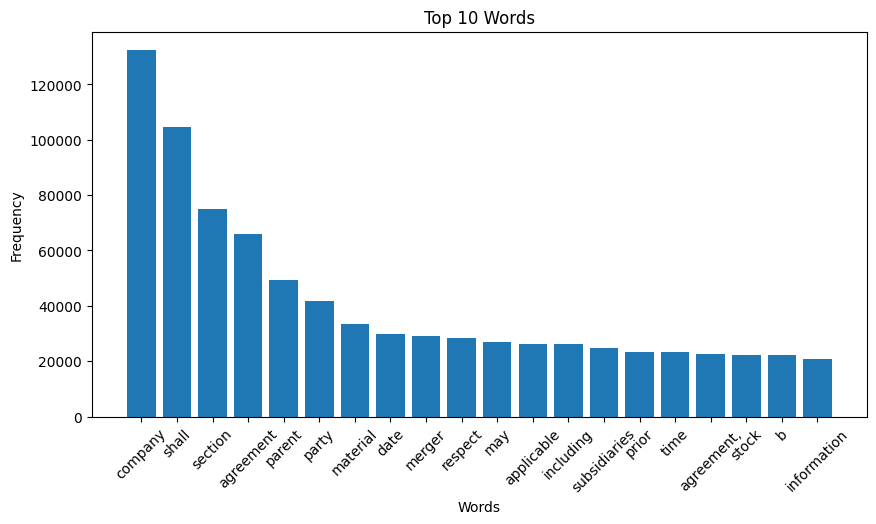

bidder;: 1


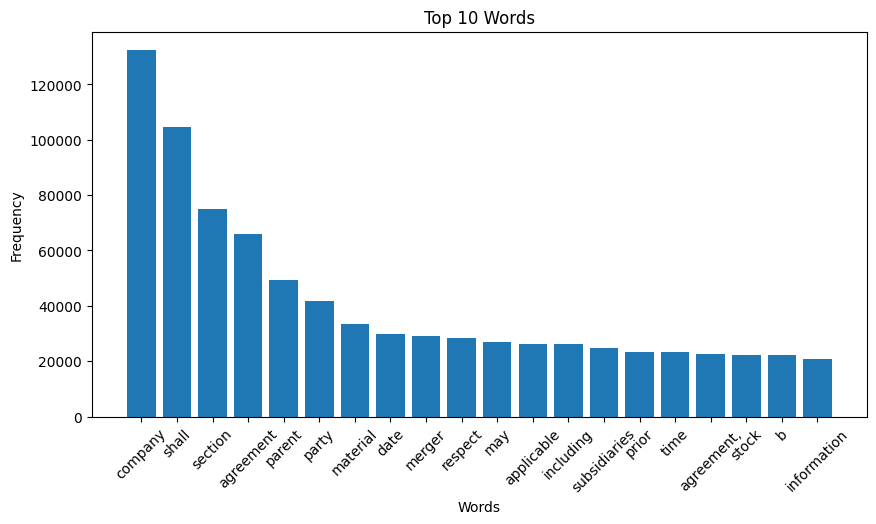

luxrail: 1


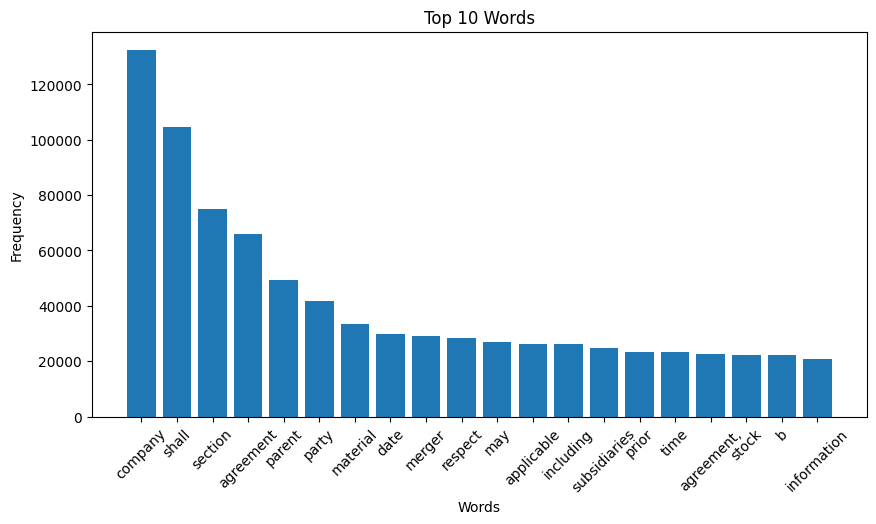

carlton: 1


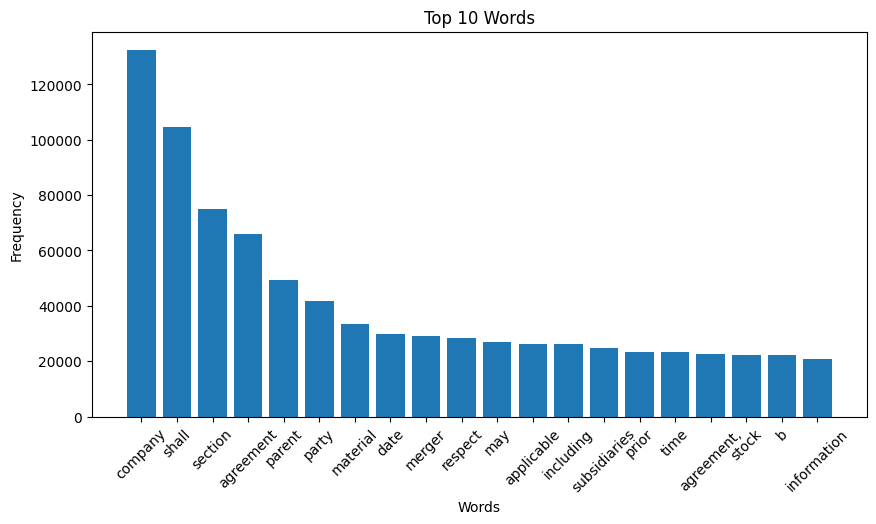

agreeement: 1


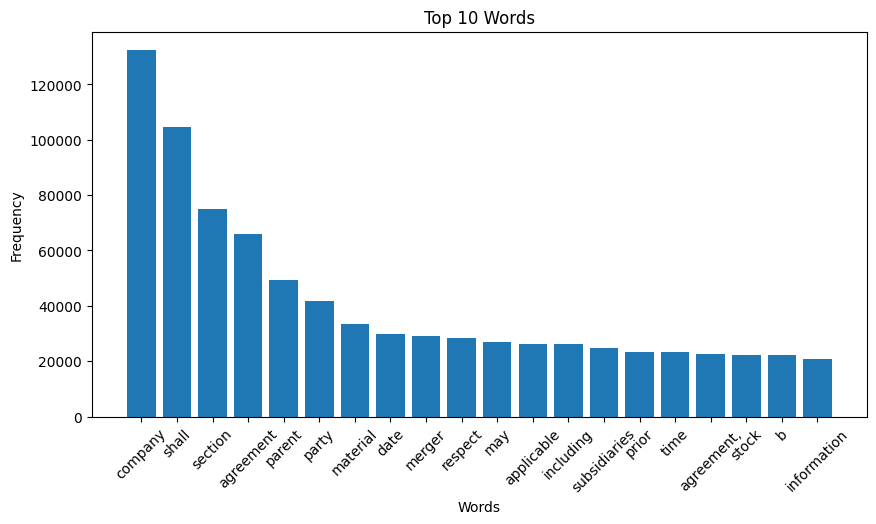

94123: 1


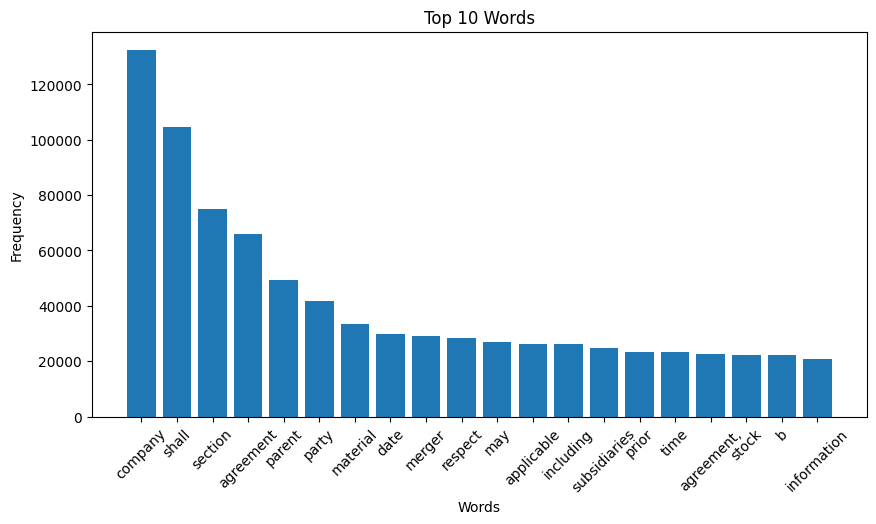

201,: 1


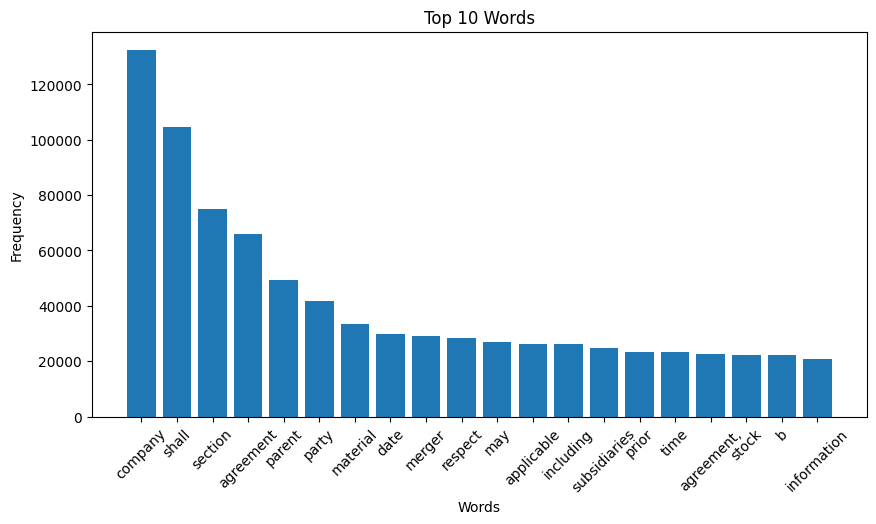

steiner: 1


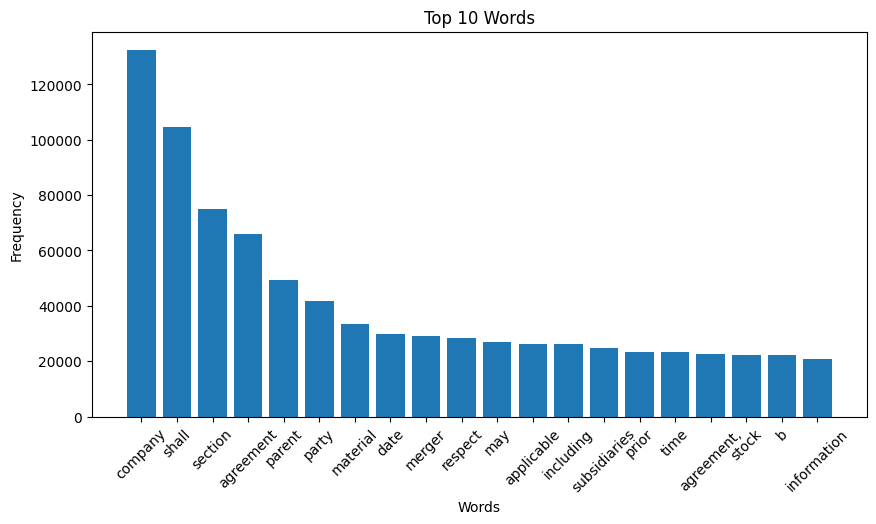

3288: 1


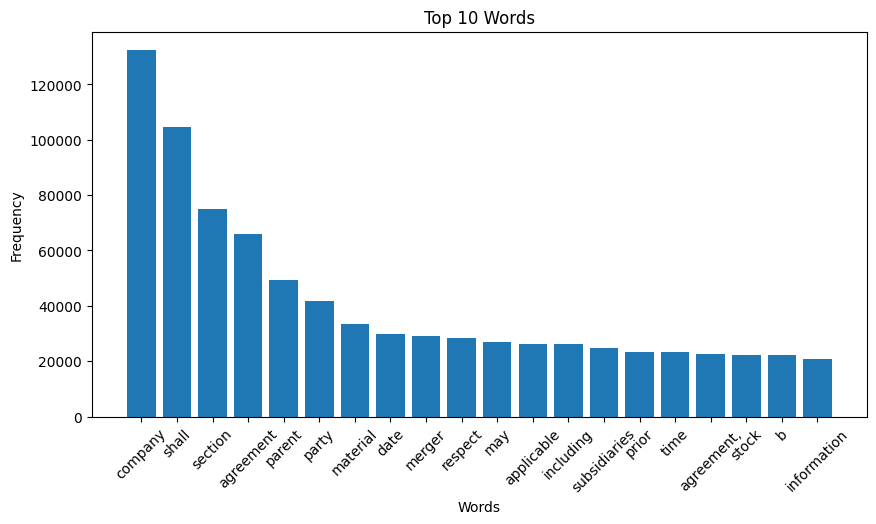

tkg.: 1


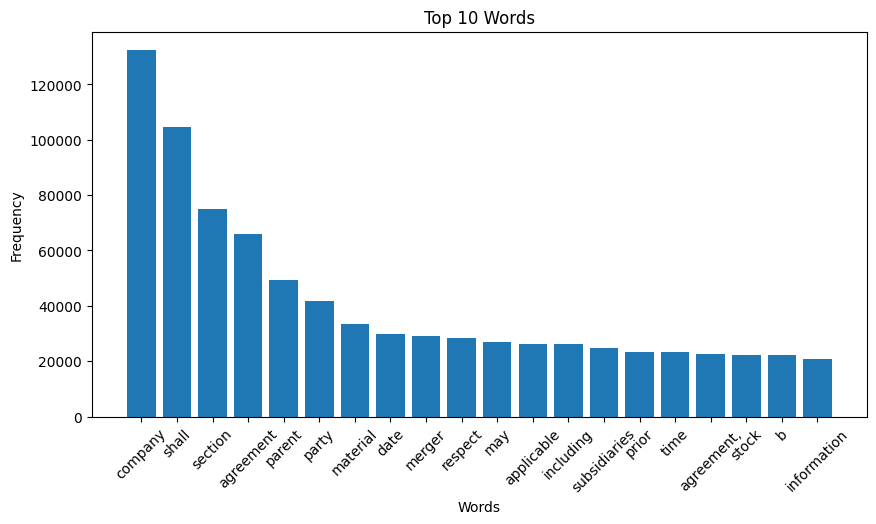

kase: 1


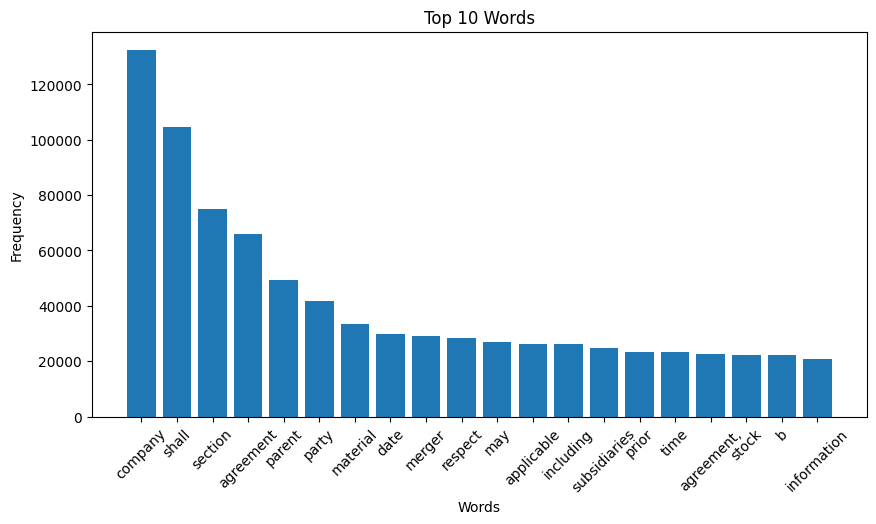

kattan: 1


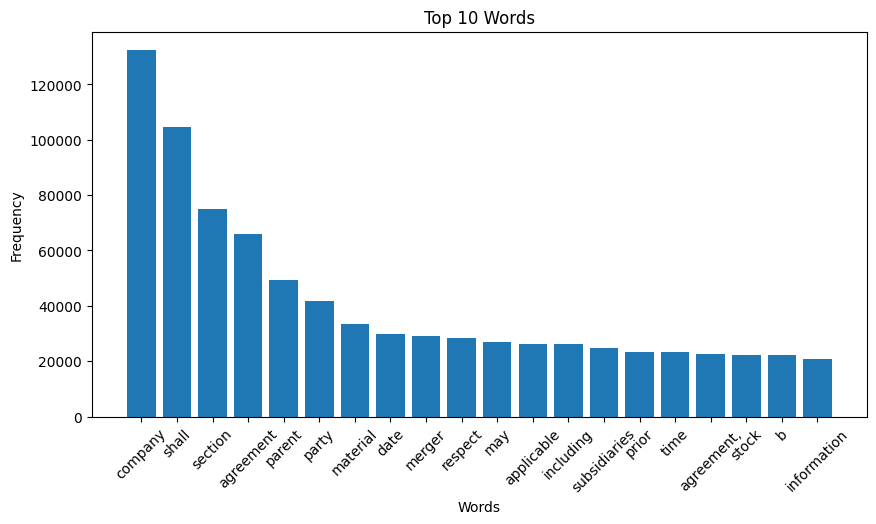

hanan: 1


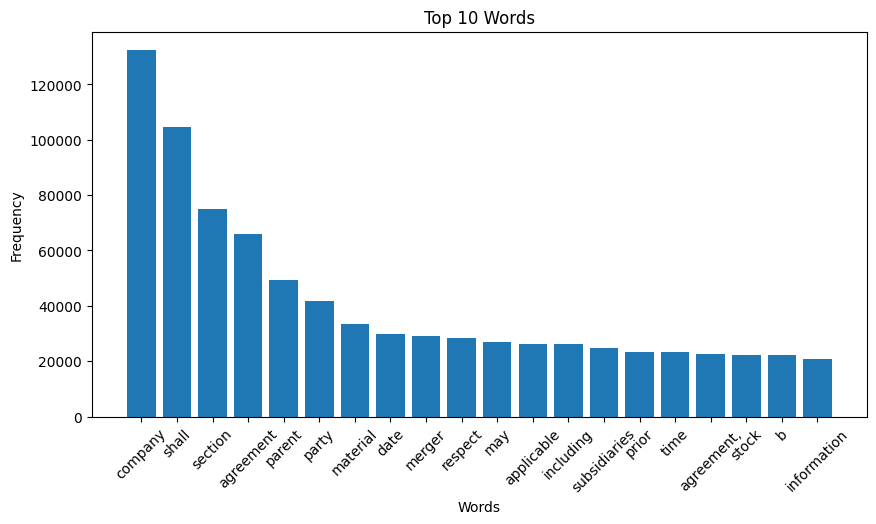

financiers: 1


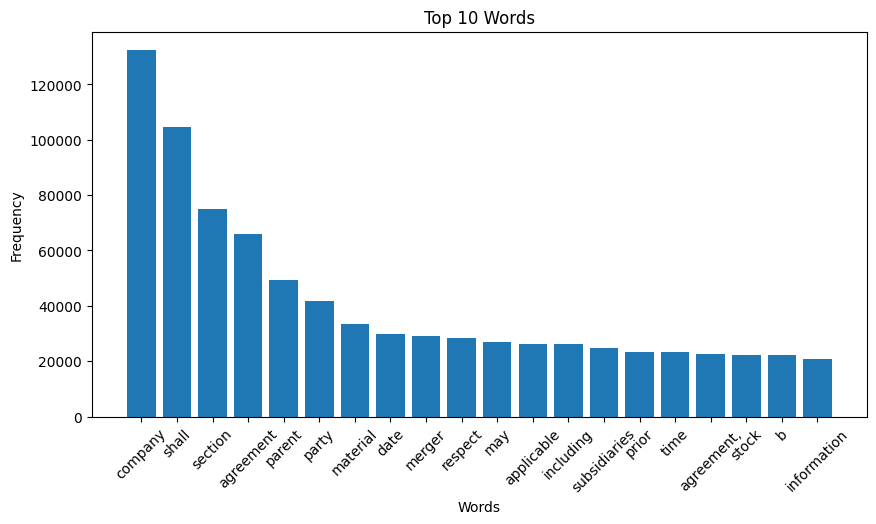

non-copyrighted: 1


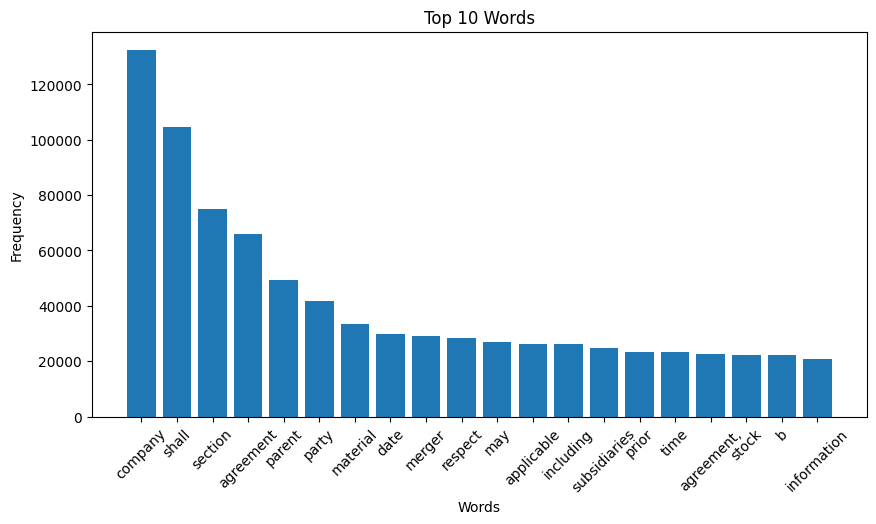

non-patented,: 1


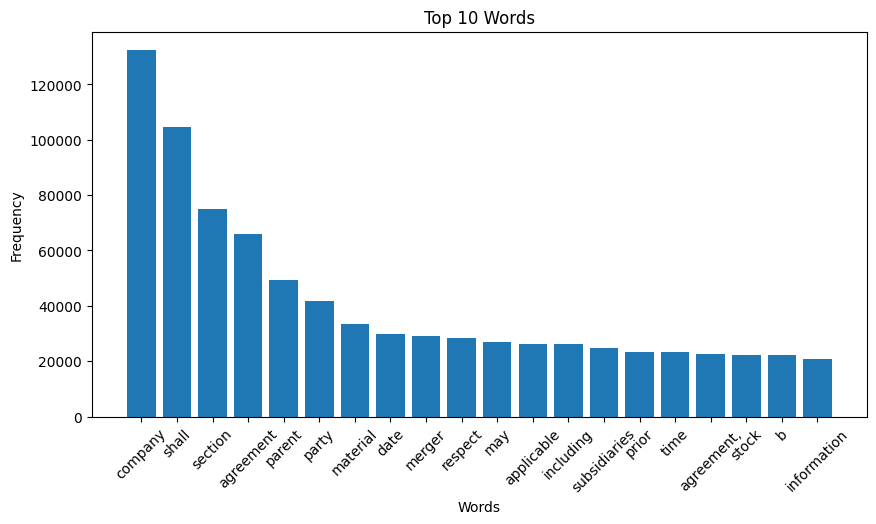

In [ ]:
#Find frequency of occurence of words

all_words = []
n=20
for doc in preprocessed_documents:
    words= doc.page_content.split()
    all_words.extend(words)
word_frequency= Counter(all_words)
most_common_words = word_frequency.most_common(n)
least_common_words = word_frequency.most_common()[:-n-1:-1]
print("Most common words:")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")
    print("\nLeast common words:")
for word, frequency in least_common_words:
    print(f"{word}: {frequency}")

    #visualise top words
    words, frequency= zip(*word_frequency.most_common(20))
    plt.figure(figsize=(10,5))
    plt.bar(words, frequency)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Top 10 Words")
    plt.xticks(rotation=45)
    plt.show()


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [ ]:
# Transform the page contents of documents
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
print("\n---similarity analysis for the first 10 docs---")
page_contents = [doc.page_content for doc in preprocessed_documents[:10]]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(page_contents)


# Compute similarity scores
similarity_matrix = cosine_similarity(tfidf_matrix)
print("similarity_matrix(first10):")
print(np.round(similarity_matrix,2))


---similarity analysis for the first 10 docs---
similarity_matrix(first10):
[[1.   0.87 0.84 0.91 0.89 0.87 0.24 0.67 0.9  0.89]
 [0.87 1.   0.93 0.89 0.92 0.89 0.25 0.65 0.91 0.91]
 [0.84 0.93 1.   0.9  0.9  0.9  0.26 0.65 0.9  0.91]
 [0.91 0.89 0.9  1.   0.92 0.93 0.28 0.71 0.93 0.94]
 [0.89 0.92 0.9  0.92 1.   0.9  0.25 0.68 0.93 0.91]
 [0.87 0.89 0.9  0.93 0.9  1.   0.28 0.7  0.92 0.95]
 [0.24 0.25 0.26 0.28 0.25 0.28 1.   0.22 0.24 0.27]
 [0.67 0.65 0.65 0.71 0.68 0.7  0.22 1.   0.71 0.71]
 [0.9  0.91 0.9  0.93 0.93 0.92 0.24 0.71 1.   0.95]
 [0.89 0.91 0.91 0.94 0.91 0.95 0.27 0.71 0.95 1.  ]]


In [ ]:
# create a list of 10 random integers
if len(preprocessed_documents) >= 10:
    random_indices = np.random.choice(len(preprocessed_documents), size=10, replace=False)
    print(f"Randomly selected documents: {random_indices}")
else:
    print("Not enough documents to select 10 random indices.")

Randomly selected documents: [406 286 436 543 550 443 500 438 525 600]


In [ ]:
# Compute similarity scores for 10 random documents
if len(preprocessed_documents) >=10:
    random_indices = np.random.choice(len(preprocessed_documents), size=10, replace=False)
    random_page_contents = [preprocessed_documents[i].page_content for i in random_indices]
    random_tfidf_matrix = vectorizer.transform(random_page_contents)
    random_similarity_matrix = cosine_similarity(random_tfidf_matrix)
    print("similarity_matrix(random10):")
    print(np.round(random_similarity_matrix,2))
else:
    print("Not enough documents to select 10 random indices.")



similarity_matrix(random10):
[[1.   0.5  0.33 0.59 0.37 0.13 0.2  0.28 0.42 0.63]
 [0.5  1.   0.18 0.36 0.28 0.09 0.14 0.2  0.35 0.33]
 [0.33 0.18 1.   0.25 0.41 0.1  0.17 0.12 0.27 0.3 ]
 [0.59 0.36 0.25 1.   0.31 0.13 0.35 0.19 0.34 0.71]
 [0.37 0.28 0.41 0.31 1.   0.1  0.21 0.17 0.42 0.28]
 [0.13 0.09 0.1  0.13 0.1  1.   0.08 0.91 0.09 0.12]
 [0.2  0.14 0.17 0.35 0.21 0.08 1.   0.11 0.19 0.31]
 [0.28 0.2  0.12 0.19 0.17 0.91 0.11 1.   0.18 0.17]
 [0.42 0.35 0.27 0.34 0.42 0.09 0.19 0.18 1.   0.29]
 [0.63 0.33 0.3  0.71 0.28 0.12 0.31 0.17 0.29 1.  ]]


### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [ ]:
# Process files and generate chunks

def generate_chunks(documents):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0, length_function= len)
  chunks = text_splitter.split_documents(documents)
  print(f"\nSplit{len(documents)} documents into {len(chunks)} chunks")
  return chunks

document_chunks = generate_chunks(preprocessed_documents)


Split698 documents into 52913 chunks


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [ ]:
# Fetch your OPENAI API Key as an environment variable
from google.colab import userdata

from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()
api_key = userdata.get('OPENAI_API_KEY')
client= OpenAI(api_key=api_key)


In [ ]:
# Initialise an embedding function
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def get_embeddings(text:str):

  response = client.embeddings.create(
      input=[text],
      model="text-embedding-ada-002"
  )
  return embedder.encode(text).tolist()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 26.2 MB/s eta 0:00:00


In [ ]:
# Add Chunks to vector DB

import faiss
import pickle
from langchain.vectorstores import FAISS

vector_DB_dir= "vector_DB"
os.makedirs(vector_DB_dir, exist_ok=True)
embedder= SentenceTransformer("all-MiniLM-L6-v2")

def add_chunks_to_vectorDB(chunks, index=None, metadata_list=None):
  texts= [chunk.page_content for chunk in chunks]
  embeddings= embedder.encode(texts)
  embeddings= np.array(embeddings).astype("float32")
  new_metadata = [{"id": i, "text": text} for i, text in enumerate(texts)]

  if index is None:
    index = faiss.IndexFlatL2(embeddings.shape[1])
    metadata_list=[]

  index.add(embeddings)
  metadata_list.extend(new_metadata)

  faiss.write_index(index, os.path.join(vector_DB_dir, "faiss_index.faiss"))
  with open(os.path.join(vector_DB_dir, "metadata.pkl"), "wb") as f:
    pickle.dump(metadata_list, f)
  print(f"Added {len(chunks)} chunks to the vector DB")
  return index, metadata_list

index, metadata_list = add_chunks_to_vectorDB(document_chunks)

### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
# Create a RAG chain

vector_DB_dir= "vector_DB"
FAISS_INDEX_PATH = os.path.join(vector_DB_dir, "faiss_index.faiss")
METADATA_PATH = os.path.join(vector_DB_dir, "metadata.pkl")

def load_faiss_index_and_metadata():
  idx= faiss.read_index(FAISS_INDEX_PATH)
  with open(METADATA_PATH, "rb") as f:
    metadata_list= pickle.load(f)
  return idx, metadata_list

def retrieve_top_k(query: str, k: int=5): # Corrected function name
    faiss_index, meta = load_faiss_index_and_metadata() # Load index and metadata
    q_veq= embedder.encode([query])
    q_veq= np.array(q_veq).astype("float32")
    distances, indices = faiss_index.search(q_veq, k)
    results= []
    for idx, distance in zip(indices[0], distances[0]):
        if idx == -1:
          continue
        text= meta[idx].get("text", "")

        results.append((idx, float(distance), text))
    return results

generator= pipeline("text2text-generation", model= "google/flan-t5-base")

#RAG ANSWER FUNCTION
def rag_answer(query= str, top_k: int=5, max_length: int=256) -> str:
  retrieved= retrieve_top_k(query, top_k) # Corrected function name
  if len(retrieved)==0:
     return "no relevant documents found in vector_DB"

  context_parts=[]
  for doc_id, distance, text in retrieved: # Unpack the tuple here
    snippet= text if len(text) < 1500 else text[:1500]+ "..."
    context_parts.append(f"[chunk_id={doc_id}]{snippet}")

  context= "\n\n".join(context_parts)

  prompt= (
      "you are helpful legal assistant. Use only the information in the context below.\n\n"
      f"CONTEXT:\n{context}\n\n"
      f"QUESTION:\n{query}\n\n"
      "if the answer is not in the context, reply: 'I do not know based on the provided documents'"
      "Answer:"
  )


  out= generator(prompt)
  return out[0]["generated_text"].strip()

#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [ ]:
# Create a function for question answering

def generate_answer(question: str, top_k: int=5) -> Dict[str, Any]:
  retrieved= retrieve_top_k(question, top_k)
  answer= rag_answer(question, top_k=top_k)
  sources =[]
  for idx, distance, text in retrieved:
    sources.append({
        "chunk_id": idx,
        "distance": distance,
        "snippet": text[:300] + "..." if len(text) > 300 else text
    })
  return {
      "question": question,
      "answer": answer,
      "sources": sources
    }




In [ ]:
# Example question
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"
result = generate_answer(question)
print(result["answer"])

for source in result["sources"]:
    print(f"Chunk ID: {source['chunk_id']}, Distance: {source['distance']:.2f}, Snippet: {source['snippet']}")


## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [ ]:
# Create a question set by taking all the questions from the benchmark data
benchmark_path= "/content/rag_legal/benchmark"
json_files= glob.glob(os.path.join(benchmark_path, "*.json"))
question_set= []
answer_set= []

for json_file in json_files:
  with open(json_file, "r") as f:
    data= json.load(f)
  if isinstance(data, list):
    for item in data:
      if "question" in item:
        question_set.append(item["question"])
  elif isinstance(data, dict):
    if "question" in data:
      question_set.extend(data["question"])
    else:
      for k, v in data.items:
        if isinstance(v, list):
          for entry in v:
            if isinstance(entry, dict) and "question" in entry:
              question_set.extend(entry["question"])
        elif isinstance(v, dict) and "question" in v:
          question_set.append(v["question"])
print(f"Number of questions: {len(question_set)}")
print(f"sample question:" question_set[:5])


# Also create a ground truth/answer set

answer_set= []
for json_file in json_files:
  with open(json_file, "r") as f:
    data= json.load(f)
    if isinstance(data, list):
      for item in data:
        if "answer" in item:
          answer_set.append(item["answer"])
    elif isinstance(data, dict):
       if "answer" in data:
           answer_set.extend(data["answer"])
       else:
        for k, v in data.items():
          if isinstance(v, list):
            for entry in v:
              if isinstance(entry, dict) and "answer" in entry:
                answer_set.extend(entry["answer"])
          elif isinstance(v, dict) and "answer" in v:
            answer_set.append(v["answer"])
print(f"Number of answers: {len(answer_set)}")
print(f"sample answer: {answer_set[:5]}")


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [ ]:
# Function to evaluate the RAG pipeline
rogue= evaluate.load("rouge")
bleu= evaluate.load("bleu")
raagas= evaluate.load("raagas")

def evaluate_RAG_pipeline(questions: List[str], ground_truths: List[str], top_k: int=5) -> Dict[str, Any]:
  generated_answers= []
  contexts=[]
  for question in questions:
    generated_answer= generate_answer(question, top_k)
    generated_answers.append(generated_answer["answer"])

    context_snippets= [src[snippet] for src in generated_answer["sources"] for snippet in ["snippet"]]
    contexts.append(context_snippets)
  #rogue
  rouge_scores= rogue.compute(predictions= generated_answers, references= ground_truths)

  #bleu
  bleu_scores= bleu.compute(predictions= generated_answers, references=[[ref] for ref in ground_truths])
  #ragas
  dataset= Dataset.from_dict({
      "question": questions,
      "ground_truth": ground_truths,
      "answer": generated_answers,
      "contexts": contexts
  })
  raagas_scores= ragas_evaluate(dataset, metrics=[
      faithfulness, answer_relevancy, context_precision, context_recall
  ])
  return {
      "rouge": rouge_scores,
      "bleu": bleu_scores,
      "raagas": ragas_scores
  }


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
# Evaluate the RAG pipeline


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.


In this project, we implemented and evaluated a RAG pipeline on a set of legal benchmark documents. The dataset was parsed into chunks, embedded into FAISS vector store and used with sequent-to-sequence model for answer generation.

key insights:


*  Data and preprocessing:
    The legalbenchmark questions and answers were sructured in JSON format. Chunking of documents insured that the retriever had sufficiently fine-grained context.

*   RAG pipeline:
     The pipeline successfully retrieved relevant document chunks and generate context-aware answers. It performs well in terms of faithfullness, relevancy, precision.


